In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import re
import math

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)


In [ ]:
"""
Computes the free energy, directly by the equation derived in the pdf
"""
def free_energy(X, mu, sigma, pie, lambd):
  
  L_TL = lambd.t() @ lambd
  mu_Tmu = mu.t() @ mu
  mu_diag = torch.diagonal(mu_Tmu, 0)
  N, D = X.size()
  one_pie = torch.ones_like(pie) - pie
  one_lambd = torch.ones_like(lambd) - lambd

  f = -N * D / 2 * np.log(sigma**2)
  

  f -= (torch.trace(X @ X.t()) - 2 * torch.trace(lambd.t() @ X @ mu) + 
   torch.trace(L_TL @ mu_Tmu) - torch.sum(torch.diagonal(L_TL, 0) * mu_diag) + 
   torch.sum(lambd @ torch.diag(mu_diag)))/ (2 * sigma**2)
  
  f += (torch.sum(lambd @ torch.log(torch.div(pie, one_pie))) + 
        N*torch.sum(torch.log(one_pie)))
  
  #this step ensures no Nan values are returned, i.e sets 0*log(0) to equal 0
  New = lambd.clone().detach()
  New = -New*torch.log(New) -(1-New)*torch.log(1-New)
  New = torch.nan_to_num(New)
  f += torch.sum(New)

  return f


In [ ]:
"""
performs the E-step by iteratively updating the columns of lambda0
"""
def MeanField(X,mu,sigma,pie,lambda0,maxsteps):
  
  log_pi = torch.log(torch.div(pie, torch.ones_like(pie) - pie))
  mu_Tmu = mu.t() @ mu
  mu_diag = torch.diagonal(mu_Tmu)
  mu_X = X @ mu

  epsilon = 1e-6
  steps = 0
  f = [free_energy(X, mu, sigma, pie, lambda0)]
  delta = 10
  while steps < maxsteps and delta > epsilon:
    for i in range(mu.size()[1]):
      exponent = ((mu_X[:,i] - lambda0 @ (mu_Tmu[:,i]) + lambda0[:,i]*mu_diag[i] 
                  - mu_diag[i]/2)/sigma**2 + log_pi[i])
      
      lambda0[:,i] = torch.reciprocal(1 + torch.exp(-exponent))
      #f.append(free_energy(X, mu, sigma, pie, lambda0))

    new_f = free_energy(X, mu, sigma, pie, lambda0)
    #delta = new_f - f[-2]
    #assert delta >= 0
    steps += 1

  return lambda0, f


In [ ]:
def m_step(X, ES, ESS):
    N, D = X.size()

    mu = ((torch.inverse(ESS) @ ES.t()) @ X).t()

    sigma = (torch.sqrt(torch.trace(X.t() @ X) + torch.trace((mu.t() @ mu) @ ESS)
             -2 * torch.trace((ES.t() @ X) @ mu))/(N*D))
    
    pie = torch.sum(ES, 0)/N
    
    return mu, sigma, pie

In [ ]:
def LearnBinFactors(X,K,iterations):
  N,D = X.size()

  #initialise parameters
  lambda0 = torch.rand((N,K)).double()
  mu = torch.ones((D,K)).double()/K
  pie = torch.rand(K).double()
  sigma = 0.2

  F_s = [free_energy(X, mu, sigma, pie, lambda0).item()]

  for i in range(iterations):
    #E-step
    lambda0, F_E = MeanField(X, mu, sigma, pie, lambda0, 50)
    
    #compute ESS
    ESS = (lambda0.t() @ lambda0 - 
           torch.diag(torch.diagonal(lambda0.t() @ lambda0)) +
           torch.diag(lambda0.sum(0)) + (1e-5)*torch.eye(K))
    #M-step
    mu, sigma, pie = m_step(X, lambda0, ESS)
    f = free_energy(X, mu, sigma, pie, lambda0).item()
    #print(f)
    F_s.append(f)
    #assert F_s[-1] >= F_s[-2]

  return mu, sigma, pie, F_s, lambda0

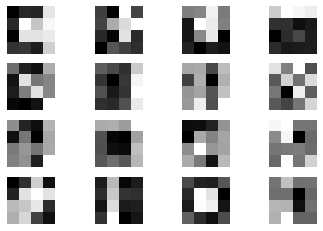

In [ ]:
N=800  # number of data points - you can increase this if you want to
       # learn better features (but it will take longer).
D=16   # dimensionality of the data

np.random.seed(0)

# Define the basic shapes of the features

m1 = [0, 0, 1, 0,
      0, 1, 1, 1,
      0, 0, 1, 0,
      0, 0, 0, 0]

m2 = [0, 1, 0, 0,
      0, 1, 0, 0,
      0, 1, 0, 0,
      0, 1, 0, 0]

m3 = [1, 1, 1, 1,
      0, 0, 0, 0,
      0, 0, 0, 0,
      0, 0, 0, 0]

m4 = [1, 0, 0, 0,
      0, 1, 0, 0,
      0, 0, 1, 0,
      0, 0, 0, 1] 

m5 = [0, 0, 0, 0,
      0, 0, 0, 0,
      1, 1, 0, 0,
      1, 1, 0, 0] 

m6 = [1, 1, 1, 1,
      1, 0, 0, 1,
      1, 0, 0, 1,
      1, 1, 1, 1] 

m7 = [0, 0, 0, 0,
      0, 1, 1, 0,
      0, 1, 1, 0,
      0, 0, 0, 0]

m8 = [0, 0, 0, 1,
      0, 0, 0, 1,
      0, 0, 0, 1,
      0, 0, 0, 1]

nfeat = 8 # number of features
rr = 0.5 + np.random.rand(nfeat, 1) * 0.5 # weight of each feature between 0.5 and 1
mut = np.array([rr[0] * m1, rr[1] * m2, rr[2] * m3, rr[3] * m4, rr[4] * m5,
                rr[5] * m6, rr[6] * m7, rr[7] * m8])
s = np.random.rand(N, nfeat) < 0.3 # each feature occurs with prob 0.3 independently 

# Generate Data - The Data is stored in Y

Y = np.dot(s, mut) + np.random.randn(N, D) * 0.1 # some Gaussian noise is added 

nrows = 13
for k in range(16):
    plt.subplot(4, 4, k + 1)
    plt.imshow(np.reshape(Y[k], (4, 4)), cmap=plt.gray(), interpolation='none')
    plt.axis('off')

plt.show()

In [ ]:
X = torch.tensor(Y).double()

In [ ]:
print(X.size())

torch.Size([800, 16])


In [ ]:
mu_2, sigma_2, pie_2, F_s_2, lambda0_2 = LearnBinFactors(X,2,30)
mu_3, sigma_3, pie_3, F_s_3, lambda0_3 = LearnBinFactors(X,3,30)
mu_4, sigma_4, pie_4, F_s_4, lambda0_4 = LearnBinFactors(X,4,30)
mu_5, sigma_5, pie_5, F_s_5, lambda0_5 = LearnBinFactors(X,5,30)
mu_6, sigma_6, pie_6, F_s_6, lambda0_6 = LearnBinFactors(X,6,30)
mu_7, sigma_7, pie_7, F_s_7, lambda0_7 = LearnBinFactors(X,7,30)
mu_8, sigma_8, pie_8, F_s_8, lambda0_8 = LearnBinFactors(X,8,30)
mu_9, sigma_9, pie_9, F_s_9, lambda0_9 = LearnBinFactors(X,9,30)
mu_10, sigma_10, pie_10, F_s_10, lambda0_10 = LearnBinFactors(X,10,30)

Text(0.5, 1.0, 'Free energy by EM for different K')

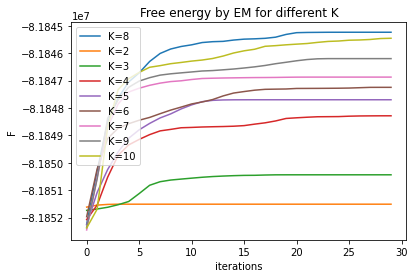

In [ ]:
plt.plot(np.arange(len(F_s_8)-1),F_s_8[1:], label = 'K=8')
plt.plot(np.arange(len(F_s_2)-1),F_s_2[1:], label = 'K=2')
plt.plot(np.arange(len(F_s_3)-1),F_s_3[1:], label = 'K=3')
plt.plot(np.arange(len(F_s_4)-1),F_s_4[1:], label = 'K=4')
plt.plot(np.arange(len(F_s_5)-1),F_s_5[1:], label = 'K=5')
plt.plot(np.arange(len(F_s_6)-1),F_s_6[1:], label = 'K=6')
plt.plot(np.arange(len(F_s_7)-1),F_s_7[1:], label = 'K=7')
plt.plot(np.arange(len(F_s_9)-1),F_s_9[1:], label = 'K=9')
plt.plot(np.arange(len(F_s_10)-1),F_s_10[1:], label = 'K=10')
plt.legend(loc="upper left")
plt.xlabel('iterations')
plt.ylabel('F')
plt.title('Free energy by EM for different K')

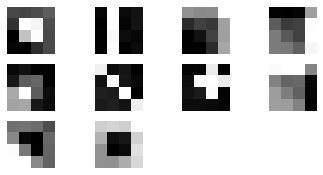

In [ ]:
for k in range(10):
    plt.subplot(4, 4, k + 1)
    plt.imshow(np.reshape(mu_10[:,k], (4, 4)), cmap=plt.gray(), interpolation='none')
    plt.axis('off')

plt.show()

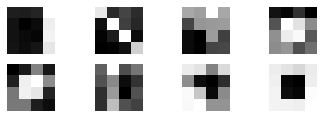

In [ ]:
for k in range(8):
    plt.subplot(4, 4, k + 1)
    plt.imshow(np.reshape(mu_8[:,k], (4, 4)), cmap=plt.gray(), interpolation='none')
    plt.axis('off')

plt.show()

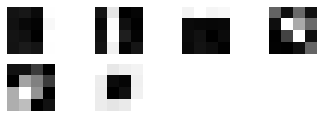

In [ ]:
for k in range(6):
    plt.subplot(4, 4, k + 1)
    plt.imshow(np.reshape(mu_6[:,k], (4, 4)), cmap=plt.gray(), interpolation='none')
    plt.axis('off')

plt.show()

In [ ]:
print(sigma_8)
print(pie_8)

tensor(0.0019, dtype=torch.float64)
tensor([0.3038, 0.3700, 0.4350, 0.4763, 0.6162, 0.3088, 0.4175, 0.3025],
       dtype=torch.float64)


In [ ]:
L = torch.rand((1,8)).double()

In [ ]:
L_a, f_a = MeanField(X[0].unsqueeze(0), mu_8, 0.01, pie_8, L.clone().detach(),400)
L_c, f_c = MeanField(X[0].unsqueeze(0), mu_8, 0.1, pie_8,  L.clone().detach(),400)
L_d, f_d = MeanField(X[0].unsqueeze(0), mu_8, 1, pie_8,  L.clone().detach(),400)



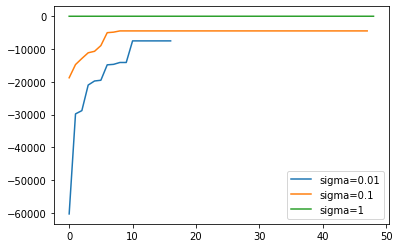

In [ ]:
plt.plot(np.arange(len(f_a)),f_a, label = 'sigma=0.01')
plt.plot(np.arange(len(f_b)),f_b, label = 'sigma=0.1')
plt.plot(np.arange(len(f_d)),f_d, label = 'sigma=1')
plt.legend(loc='lower right')

In [ ]:
print(len(f_a))
print(len(f_b))
print(len(f_d))

17
41
49


In [ ]:
f_a = f_a + 32*[f_a[-1]]
f_b = f_b + 7*[f_b[-1]]


In [ ]:
diff_a = [j-i for i, j in zip(f_a[:-1], f_a[1:])]
diff_b = [j-i for i, j in zip(f_b[:-1], f_b[1:])]
diff_d = [j-i for i, j in zip(f_d[:-1], f_d[1:])]

In [ ]:
diff_a = [torch.nan_to_num(torch.log(i),0,0,0) for i in diff_a]
diff_b = [torch.nan_to_num(torch.log(i),0,0,0) for i in diff_b]
diff_d = [torch.nan_to_num(torch.log(i),0,0,0) for i in diff_d]

In [ ]:
diff_a[8:]=41*[-25]
diff_b[8:]=41*[-25]

Text(0.5, 1.0, 'Free energy iterated over E-step')

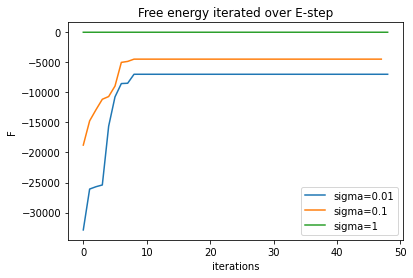

In [ ]:
plt.plot(np.arange(len(f_a)),f_a, label = 'sigma=0.01')
plt.plot(np.arange(len(f_b)),f_b, label = 'sigma=0.1')
plt.plot(np.arange(len(f_d)),f_d, label = 'sigma=1')
plt.legend(loc='lower right')
plt.xlabel('iterations')
plt.ylabel('F')
plt.title('Free energy iterated over E-step')

Text(0.5, 1.0, 'Log-difference in free energy iterated over E-step')

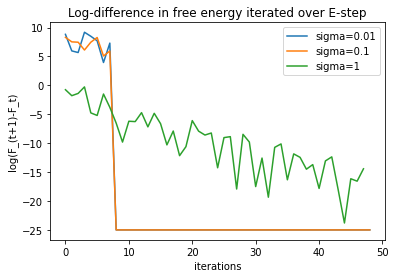

In [ ]:
plt.plot(np.arange(len(diff_a)),diff_a, label = 'sigma=0.01')
plt.plot(np.arange(len(diff_b)),diff_b, label = 'sigma=0.1')
plt.plot(np.arange(len(diff_d)),diff_d, label = 'sigma=1')
plt.legend(loc='upper right')
plt.xlabel('iterations')
plt.ylabel('log(F_(t+1)-F_t)')
plt.title('Log-difference in free energy iterated over E-step')

In [ ]:
print(f_a)

[tensor(-31742.0182, dtype=torch.float64), tensor(-21714.5580, dtype=torch.float64), tensor(-20150.3872, dtype=torch.float64), tensor(-19186.7908, dtype=torch.float64), tensor(-16259.5300, dtype=torch.float64), tensor(-12551.7786, dtype=torch.float64), tensor(-9871.9138, dtype=torch.float64), tensor(-9355.8516, dtype=torch.float64), tensor(-6985.9466, dtype=torch.float64), tensor(-6985.9466, dtype=torch.float64), tensor(-6985.9466, dtype=torch.float64), tensor(-6985.9466, dtype=torch.float64), tensor(-6985.9466, dtype=torch.float64), tensor(-6985.9466, dtype=torch.float64), tensor(-6985.9466, dtype=torch.float64), tensor(-6985.9466, dtype=torch.float64), tensor(-6985.9466, dtype=torch.float64), tensor(-6985.9466, dtype=torch.float64), tensor(-6985.9466, dtype=torch.float64), tensor(-6985.9466, dtype=torch.float64), tensor(-6985.9466, dtype=torch.float64), tensor(-6985.9466, dtype=torch.float64), tensor(-6985.9466, dtype=torch.float64), tensor(-6985.9466, dtype=torch.float64), tensor(-6

In [ ]:
print(diff_a)

[tensor(8.8240, dtype=torch.float64), tensor(5.9600, dtype=torch.float64), tensor(5.6785, dtype=torch.float64), tensor(9.1872, dtype=torch.float64), tensor(8.4912, dtype=torch.float64), tensor(7.7052, dtype=torch.float64), tensor(3.9554, dtype=torch.float64), tensor(7.3083, dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0.,

In [ ]:
print([torch.nan_to_num(torch.log(i),0,0,0) for i in diff_d])

[tensor(-0.1669, dtype=torch.float64), tensor(-0.7601, dtype=torch.float64), tensor(-1.5255, dtype=torch.float64), tensor(-2.7800, dtype=torch.float64), tensor(-5.3007, dtype=torch.float64), tensor(-2.5858, dtype=torch.float64), tensor(-1.1332, dtype=torch.float64), tensor(-3.6622, dtype=torch.float64), tensor(-4.7956, dtype=torch.float64), tensor(-3.7024, dtype=torch.float64), tensor(-8.8376, dtype=torch.float64), tensor(-5.9843, dtype=torch.float64), tensor(-3.9050, dtype=torch.float64), tensor(-8.9750, dtype=torch.float64), tensor(-4.4774, dtype=torch.float64), tensor(-9.4416, dtype=torch.float64), tensor(-15.0944, dtype=torch.float64), tensor(-6.6549, dtype=torch.float64), tensor(-10.3058, dtype=torch.float64), tensor(-8.5241, dtype=torch.float64), tensor(-7.1000, dtype=torch.float64), tensor(-10.5718, dtype=torch.float64), tensor(-8.6548, dtype=torch.float64), tensor(-9.8210, dtype=torch.float64), tensor(-14.6472, dtype=torch.float64), tensor(-11.3157, dtype=torch.float64), tensor